<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="40%"
     alt="Dask logo">

Custom Computations with `dask.delayed` and `for` loops
===========

*Because the real world is a messy place*

This example uses [dask.delayed](http://dask.pydata.org/en/latest/delayed.html) to construct a parallel [dask.dataframe](http://dask.pydata.org/en/latest/dataframe.html) from a nested directory of data stored in a custom format, [feather](https://github.com/wesm/feather).  It is a good example of using dask.delayed to handle messy situations in the real world and then hand those situations off to dask.dataframe for clean processing.

## Example: Hierarchically stored data in custom format

*  Hierarchical storage: Custom directory structure with filenames encoding columns
*  Feather: New Dataframe format that came out two weeks ago

### See contents of local directory


In [1]:
!ls 

2016-01-01  2016-01-09	2016-01-17  2016-01-25	dask.pdf
2016-01-02  2016-01-10	2016-01-18  2016-01-26	Imperative-Feather.ipynb
2016-01-03  2016-01-11	2016-01-19  2016-01-27	mydask.png
2016-01-04  2016-01-12	2016-01-20  2016-01-28	work.py
2016-01-05  2016-01-13	2016-01-21  2016-01-29
2016-01-06  2016-01-14	2016-01-22  2016-01-30
2016-01-07  2016-01-15	2016-01-23  2016-01-31
2016-01-08  2016-01-16	2016-01-24  create.py


### See contents of subdirectory, feather files named by symbol (like stocks)

In [2]:
!ls 2016-01-01

BV  EX	HXMW  MNX  PL  SKHT  UU  XHV


### Some symbol overlap in other directories

In [3]:
!ls 2016-01-02

BV  EX	HXMW  MNX  PL  PWU  SKHT  UU  WNT  XHV


### Each file is a feather encoded dataframe (with toy data inside)

In [4]:
import feather
df = feather.read_dataframe('2016-01-01/BV')
df.head()

,A,B,C,D
0,-0.351246,-1.692870,-0.397125,0.384644
1,-1.423015,-0.745109,1.990852,-0.235062
2,-1.008925,0.196380,1.587710,-0.273950
3,0.605530,0.538377,0.159150,0.224017
4,-0.647940,0.219201,0.939612,0.829770


### We want to encode the filename and directory as column data

In [5]:
import pandas as pd
df.assign(date=pd.Timestamp('2016-01-01'), symbol='BV').head()

,A,B,C,D,date,symbol
0,-0.351246,-1.692870,-0.397125,0.384644,2016-01-01,BV
1,-1.423015,-0.745109,1.990852,-0.235062,2016-01-01,BV
2,-1.008925,0.196380,1.587710,-0.273950,2016-01-01,BV
3,0.605530,0.538377,0.159150,0.224017,2016-01-01,BV
4,-0.647940,0.219201,0.939612,0.829770,2016-01-01,BV


### but we have lots of files, so we want to do it in parallel

In [6]:
!tree .

.
├── 2016-01-01
│   ├── BV
│   ├── EX
│   ├── HXMW
│   ├── MNX
│   ├── PL
│   ├── SKHT
│   ├── UU
│   └── XHV
├── 2016-01-02
│   ├── BV
│   ├── EX
│   ├── HXMW
│   ├── MNX
│   ├── PL
│   ├── PWU
│   ├── SKHT
│   ├── UU
│   ├── WNT
│   └── XHV
├── 2016-01-03
│   ├── BV
│   ├── EX
│   ├── HXMW
│   ├── PL
│   ├── PWU
│   ├── SKHT
│   ├── WNT
│   └── XHV
├── 2016-01-04
│   ├── BV
│   ├── EX
│   ├── HXMW
│   ├── MNX
│   ├── PL
│   ├── PWU
│   ├── SKHT
│   ├── UU
│   ├── WNT
│   └── XHV
├── 2016-01-05
│   ├── BV
│   ├── EX
│   ├── HXMW
│   ├── PL
│   ├── PWU
│   ├── UU
│   └── WNT
├── 2016-01-06
│   ├── BV
│   ├── EX
│   ├── HXMW
│   ├── MNX
│   └── UU
├── 2016-01-07
│   ├── BV
│   ├── EX
│   ├── HXMW
│   ├── MNX
│   ├── PL
│   ├── PWU
│   ├── UU
│   ├── WNT
│   └── XHV
├── 2016-01-08
│   ├── BV
│   ├── MNX
│   ├── PL
│   ├── PWU
│   ├── SKHT
│   ├── UU
│   └── XHV
├── 2016-01-09
│   ├── BV
│   ├── EX
│   ├── PWU
│   ├── SKHT
│   ├── UU
│   └── WNT
├── 2016-01-10
│   ├── EX
│   ├── HXMW
│  

### but no canned function exists for our use case :(

In [7]:
import dask.dataframe as dd

dd.read_nested_directory_of_feather_files('.')

AttributeError: 'module' object has no attribute 'read_nested_directory_of_feather_files'

### Fortunately we can use `dask.delayed` to create custom parallel computations

The `dask.delayed` function turns a normal function call in normal code to instead produce a task in a task graph.  Can create strange computations very easily with generic Python code.

In [8]:
from dask import delayed
from glob import glob
import os

lazy_dataframes = []
for directory in glob('2016-*'):
    for symbol in os.listdir(directory):
        filename = os.path.join(directory, symbol)
        df = delayed(feather.read_dataframe)(filename)
        df = delayed(pd.DataFrame.assign)(df, date=pd.Timestamp(directory),
                                              symbol=symbol)
        lazy_dataframes.append(df)

In [9]:
lazy_dataframes[0]

Value('assign-8ee86514-7230-4734-977d-7effa2499a0f')

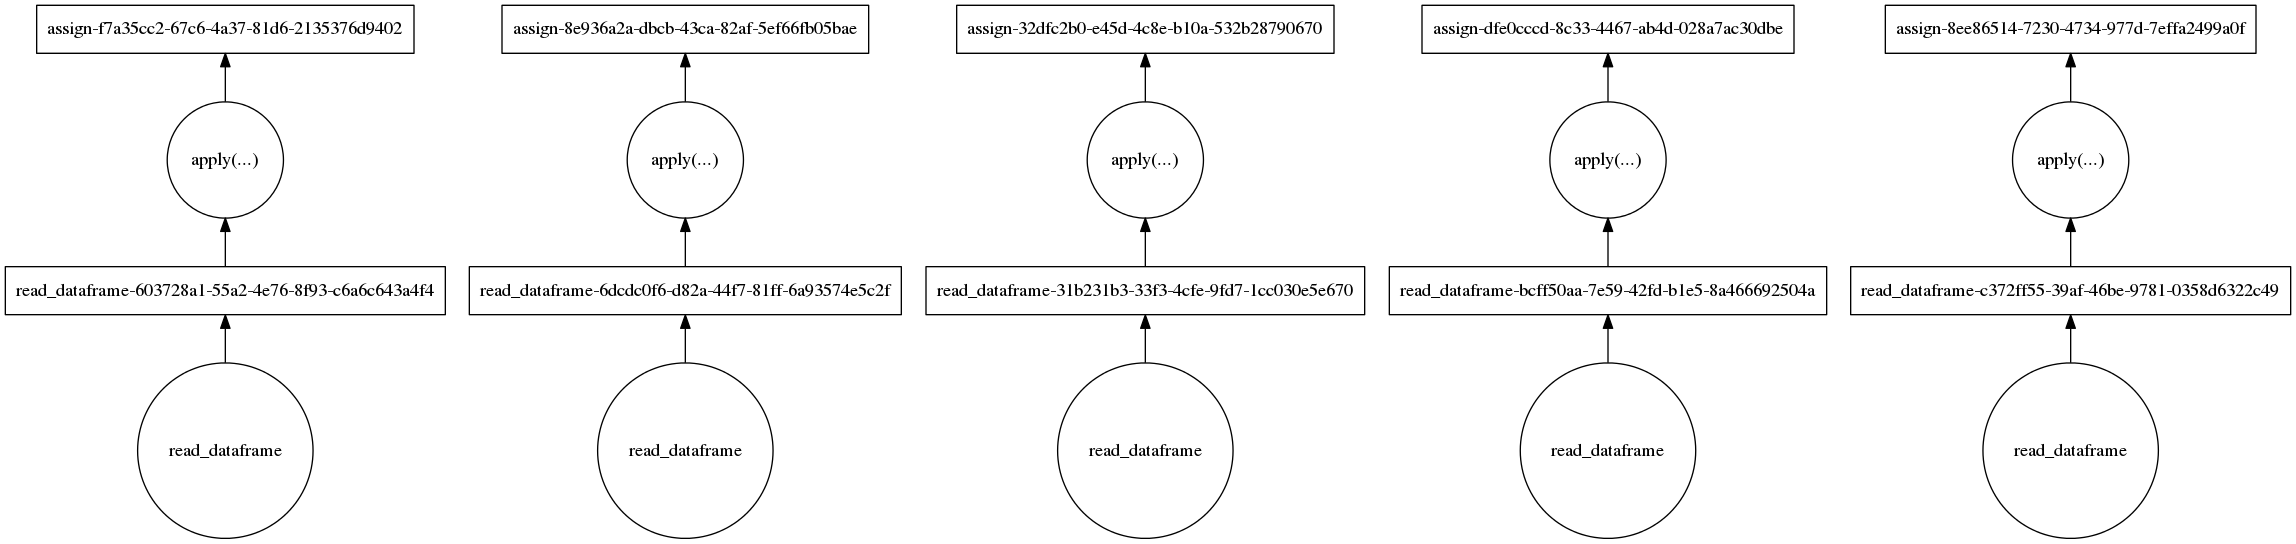

In [10]:
from dask import visualize
visualize(*lazy_dataframes[:5])

### Can manually construct graph further

In [11]:
sums = [df.A.sum() for df in lazy_dataframes]
total = delayed(sum)(sums)
total.compute()

303.17973331250477

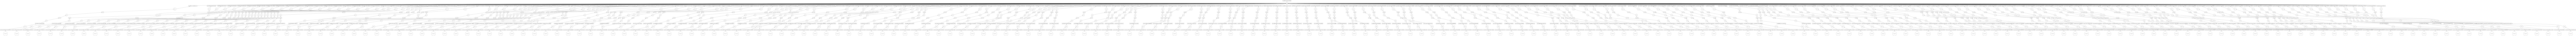

In [12]:
visualize(total)

### Or can jump to dataframes after the messy work is done

In [13]:
df = dd.from_imperative(lazy_dataframes, metadata=lazy_dataframes[0].compute())
df.head()

,A,B,C,D,date,symbol
0,0.897231,-0.998175,0.080038,-1.298049,2016-01-27,HXMW
1,0.938731,-0.501920,1.509223,0.197417,2016-01-27,HXMW
2,0.313747,0.956188,-0.976683,0.582431,2016-01-27,HXMW
3,-0.567806,0.395609,0.998049,0.461580,2016-01-27,HXMW
4,-1.161491,-0.721527,1.039551,0.475816,2016-01-27,HXMW


In [14]:
df

dd.DataFrame<from-imperative-debe1714eec2aa8a6afcfbf05b1f2676, divisions=(None, None, None, ..., None, None)>

In [15]:
df.A.std().compute()

0.99960528907014212

## Good for custom pipelines and general task scheduling

![](http://matthewrocklin.com/slides/images/task-scheduling.svg)

## Also good for parallelizing existing projects